In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
import strategies as custom

In [17]:
from importlib import reload
custom = reload(custom)

In [64]:
# Download historical data
start_date = "2021-01-01"
end_date =  "2023-10-31"

cerebro = bt.Cerebro()
for symbol in ['QQQ', 'SPY', 'GLD']:
    data = bt.feeds.PandasData(dataname=yf.download(symbol, start=start_date, end=end_date,multi_level_index=False))
    cerebro.adddata(data, name=symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
df=yf.download("QQQ", start="2006-06-30", end=end_date,multi_level_index=False)
df.head()


[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2006-06-30,33.397228,33.715952,33.319700,33.698724,82719200
2006-07-03,33.595352,33.595352,33.431684,33.500596,21598500
2006-07-05,32.863136,33.319687,32.811450,33.285230,93724000
2006-07-06,32.828693,33.147418,32.742549,32.966520,70615200
2006-07-07,32.466896,32.880377,32.363527,32.647797,108063300


In [15]:
class PrintClose(bt.Strategy):
    params = (
        ('qqq_ma_period', 30),
        ('spy_fast_ma', 50),
        ('spy_slow_ma', 200),
    )
    def __init__(self):
        #Keep a reference to the "close" line in the data[0] dataseries
        self.qqq = self.datas[0]
        self.spy = self.datas[1]
        self.gld = self.datas[2]

        self.qqq_ma = bt.indicators.SimpleMovingAverage(self.qqq, period=self.p.qqq_ma_period)
        self.spy_fast_ma = bt.indicators.SimpleMovingAverage(self.spy, period=self.p.spy_fast_ma)
        self.spy_slow_ma = bt.indicators.SimpleMovingAverage(self.spy, period=self.p.spy_slow_ma)

        self.qqq_cross = bt.indicators.CrossOver(self.qqq, self.qqq_ma)
        self.spy_cross = bt.indicators.CrossOver(self.spy_fast_ma, self.spy_slow_ma)

    def log(self, txt, value1=None, value2=None, value3=None):
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt} {value1} {value2} {value3}') 

    def next(self):
        # self.log('qqq: ', self.qqq[0]) 
        self.log('spy_cross: ', self.spy_cross[0], self.spy_fast_ma[0], self.spy_slow_ma[0]) 
        self.log('qqq_cross: ', self.qqq_cross[0], self.qqq_ma[0], self.qqq[0]) 
        self.log('qqq_cross T-1: ', self.qqq_cross[-1]) 

cerebro = bt.Cerebro()

start_date = "2021-01-01"
end_date =  "2023-10-31"
for symbol in ['QQQ', 'SPY', 'GLD']:
    data = bt.feeds.PandasData(dataname=yf.download(symbol, start=start_date, end=end_date,multi_level_index=False))
    cerebro.adddata(data, name=symbol)

#Add strategy to Cerebro
cerebro.addstrategy(PrintClose)

#Run Cerebro Engine
cerebro.run()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2021-10-19 spy_cross:  0.0 421.6872802734375 395.4598361206055
2021-10-19 qqq_cross:  0.0 359.66493733723956 367.50946044921875
2021-10-19 qqq_cross T-1:  0.0 None None
2021-10-20 spy_cross:  0.0 421.89982849121094 395.8636099243164
2021-10-20 qqq_cross:  0.0 359.4894602457682 367.0298156738281
2021-10-20 qqq_cross T-1:  0.0 None None
2021-10-21 spy_cross:  0.0 422.11397155761716 396.2625273132324
2021-10-21 qqq_cross:  0.0 359.4313944498698 369.2713623046875
2021-10-21 qqq_cross T-1:  0.0 None None
2021-10-22 spy_cross:  0.0 422.2938629150391 396.632995300293
2021-10-22 qqq_cross:  0.0 359.36376037597654 366.1684875488281
2021-10-22 qqq_cross T-1:  0.0 None None
2021-10-25 spy_cross:  0.0 422.50470092773435 397.0048503112793
2021-10-25 qqq_cross:  0.0 359.4295593261719 369.9172668457031
2021-10-25 qqq_cross T-1:  0.0 None None
2021-10-26 spy_cross:  0.0 422.7033984375 397.39079666137695
2021-10-26 qqq_cross:  0.0 359.5690541585287 371.08197021484375
2021-10-26 qqq_cross T-1:  0.0 None

In [5]:
# Print results
def results_analyzer(results, start_date, end_date):

    print(f"Sharpe Ratio: {results[0].analyzers.sharpe_ratio.get_analysis()['sharperatio']}")
    print(f"Total compound return: {results[0].analyzers.returns.get_analysis()['rtot']:.2%}")
    print(f"Average return for the entire period (timeframe specific): {results[0].analyzers.returns.get_analysis()['ravg']:.2%}")
    print(f"Annualized/Normalized return expressed in 100%: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
    print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
    print("Max Moneydown: "+str(results[0].analyzers.drawdown.get_analysis()['max']['moneydown']))
    print("Max Drawdown Length: "+str(results[0].analyzers.drawdown.get_analysis()['max']['len']))

def cerebro_runner(start_date, end_date, strategy, tickers, setcash=100000):
    cerebro = bt.Cerebro()
    for symbol in tickers:
        data = bt.feeds.PandasData(dataname=yf.download(symbol, start=start_date, end=end_date, multi_level_index=False))
        cerebro.adddata(data, name=symbol)
    cerebro.addstrategy(strategy)
    cerebro.broker.setcash(100000)
    cerebro.broker.set_coc(True)
    # cerebro.broker.set_fundmode(True)
    cerebro.addsizer(bt.sizers.AllInSizerInt, percents = 99.8)  
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.PyFolio)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True)  # track fund value
    
    # Run the backtest
    results = cerebro.run()
    print("Backtest Period From "+start_date+" To "+ end_date)
    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")
    results_analyzer(results, start_date, end_date)
    cerebro.plot(iplot = False)
    pyfolio = results[0].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
    transaction_data = transactions.merge(positions, how='left', left_index=True, right_index=True).merge(returns, how='left', left_index=True, right_index=True)
    return transaction_data

### Backtest on SMA strategy with SPY QQQ GLD

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtest Period From 2021-01-01 To 2023-10-31
Final Portfolio Value: $99369.82
Sharpe Ratio: 0.003886334202165849
Total compound return: -0.63%
Average return for the entire period (timeframe specific): -0.00%
Annualized/Normalized return expressed in 100%: -0.22%
Max Drawdown: 29.28%
Max Moneydown: 32082.582473754883
Max Drawdown Length: 337


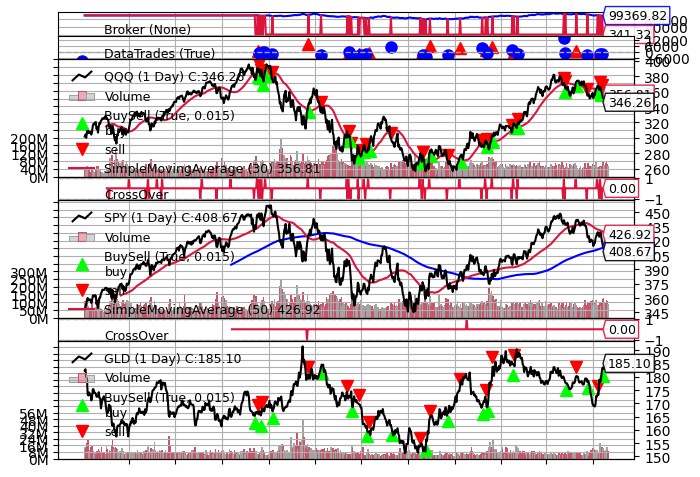

In [10]:
start_date = "2021-01-01"
end_date =  "2023-10-31"
tickers = ['QQQ', 'SPY', 'GLD']
strategy = custom.QQQ_SPY_SMA
trans = cerebro_runner(start_date, end_date, strategy, tickers, setcash=100000)


In [14]:
trans.head()

,amount,price,sid,symbol,value,GLD,cash,return
date,,,,,,,,
2021-12-03 00:00:00+00:00,603,165.240005,2,GLD,-99639.723312,100477.892944,360.276688,0.008382
2021-12-08 00:00:00+00:00,-603,166.809998,2,GLD,100586.428528,0.000000,100946.705215,0.000000
2021-12-09 00:00:00+00:00,257,391.137634,0,QQQ,-100522.372009,0.000000,424.333206,-0.014652
2021-12-10 00:00:00+00:00,-257,385.382324,0,QQQ,99043.257324,0.000000,99467.590530,0.000000
2021-12-13 00:00:00+00:00,254,389.571594,0,QQQ,-98951.184937,0.000000,516.405594,-0.014372


### Benchmark strategy: QQQ and SPY buy and hold

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2006-06-30 QQQ BUY CREATED --- Price: 33.40 
BUY EXECUTED, Price: 33.40, Cost: 99790.93, Comm 0.00
Backtest Period From 2005-09-14 To 2024-10-31
Final Portfolio Value: $1481004.71
Sharpe Ratio: 0.6725950514175058
Total compound return: 269.53%
Average return for the entire period (timeframe specific): 0.06%
Annualized/Normalized return expressed in 100%: 15.15%
Max Drawdown: 53.33%
Max Moneydown: 414943.7277832031
Max Drawdown Length: 781


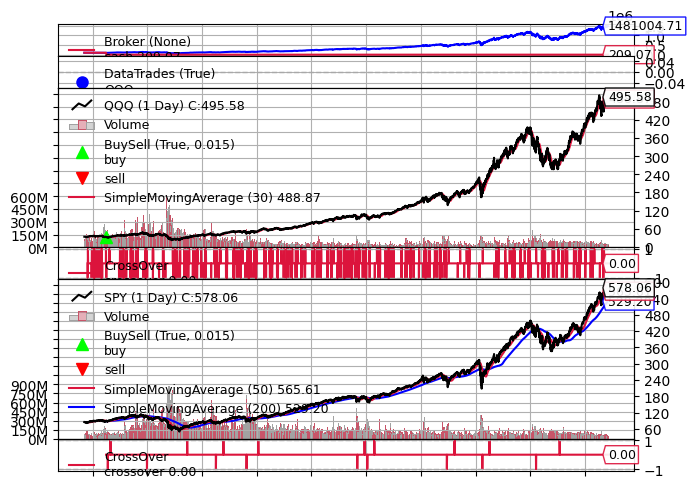

In [21]:
start_date = "2005-09-14"
end_date =  "2024-10-31"
tickers = ['QQQ', 'SPY']
strategy = custom.QQQ_SPY_Signal_Buy_and_Hold
transactions = cerebro_runner(start_date, end_date, strategy, tickers, setcash=100000)

In [7]:
transactions
#pyfolio.get_pf_items()

,amount,price,sid,symbol,value,SPY,cash,return
date,,,,,,,,
2006-07-03 00:00:00+00:00,2988,33.397232,0,QQQ,-99790.929382,0.0,209.070618,0.00592


### Benchmark on SPY Buy and Hold

[*********************100%***********************]  1 of 1 completed


2006-06-30 SPY BUY CREATED --- Price: 89.64 
BUY EXECUTED, Price: 89.64, Cost: 99773.16, Comm 0.00
Backtest Period From 2006-06-30 To 2024-10-31
Final Portfolio Value: $643612.58
Sharpe Ratio: 0.634173235396394
Total compound return: 186.19%
Average return for the entire period (timeframe specific): 0.04%
Annualized/Normalized return expressed in 100%: 10.70%
Max Drawdown: 55.09%
Max Moneydown: 124648.15383911133
Max Drawdown Length: 1223


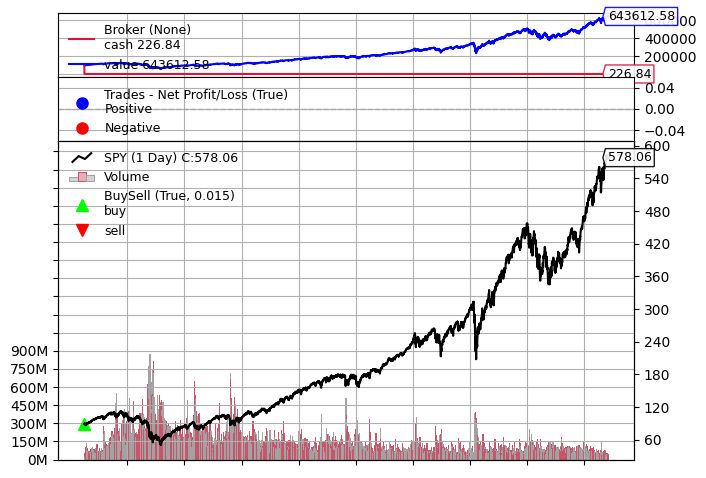

In [19]:
start_date = "2006-06-30"
end_date =  "2024-10-31"
tickers = ['SPY']
strategy = custom.SPY_Buy_and_Hold
transactions = cerebro_runner(start_date, end_date, strategy, tickers, setcash=100000)

In [20]:
transactions

,amount,price,sid,symbol,value,SPY,cash,return
date,,,,,,,,
2006-07-03 00:00:00+00:00,1113,89.643448,0,SPY,-99773.157486,100180.758751,226.842514,0.004076


In [130]:
positions.head(300)

,GLD,cash
Datetime,,
2005-09-13 00:00:00+00:00,0.0,100000.000000
2005-09-14 00:00:00+00:00,0.0,100000.000000
2005-09-15 00:00:00+00:00,0.0,100000.000000
2005-09-16 00:00:00+00:00,0.0,100000.000000
2005-09-19 00:00:00+00:00,0.0,100000.000000
...,...,...
2006-11-13 00:00:00+00:00,0.0,223.657043
2006-11-14 00:00:00+00:00,0.0,223.657043
2006-11-15 00:00:00+00:00,0.0,223.657043


In [37]:
transactions.merge(positions, how='left', left_index=True, right_index=True).merge(returns, how='left', left_index=True, right_index=True).to_csv('backtest_new_t_minus_1.csv')

In [27]:
returns.to_csv('returns_new.csv')

In [ ]:
from collections import defaultdict
class IndicatorObserver(bt.observer.Observer):
    lines = ('qqq_ma', 'spy_fast_ma', 'spy_slow_ma')
    plotlines = dict(
        qqq_ma=dict(color='blue'),
        spy_fast_ma=dict(color='green'),
        spy_slow_ma=dict(color='red')
    )

    def next(self):
        self.lines.qqq_ma[0] = self.strategy.qqq_ma[0]
        self.lines.spy_fast_ma[0] = self.strategy.spy_fast_ma[0]
        self.lines.spy_slow_ma[0] = self.strategy.spy_slow_ma[0]
